Saving pngtree-simple-tree-with-lots-of-green-leaves-png-image_18352339.png to pngtree-simple-tree-with-lots-of-green-leaves-png-image_18352339.png


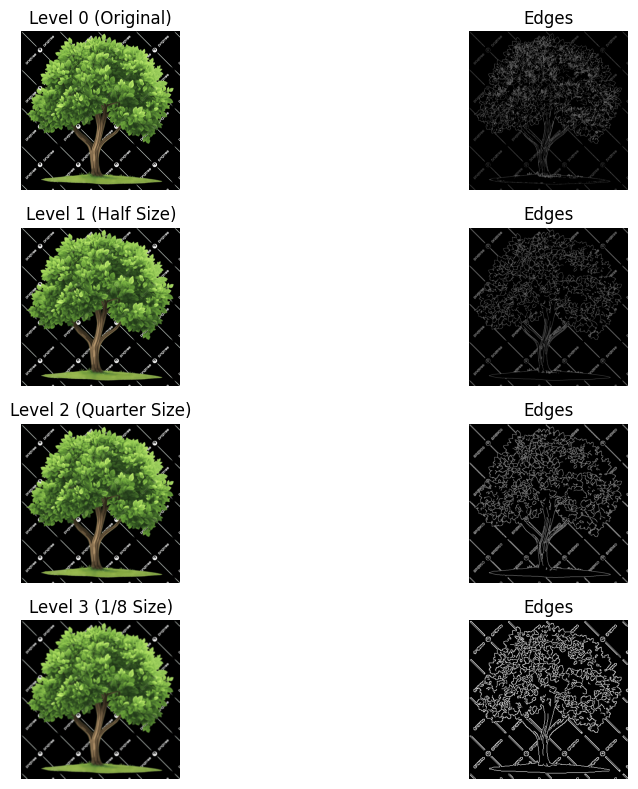

In [1]:
# Install OpenCV if needed
!pip install opencv-python

import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

# 1️⃣ Upload an image
uploaded = files.upload()

# Read uploaded image
image_path = list(uploaded.keys())[0]
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2️⃣ Generate Gaussian Pyramid
level0 = img
level1 = cv2.pyrDown(level0)   # Half size
level2 = cv2.pyrDown(level1)   # Quarter size
level3 = cv2.pyrDown(level2)   # One-eighth size

pyramid = [level0, level1, level2, level3]

# 3️⃣ Apply Canny Edge Detection at each level
edges = []
for level in pyramid:
    gray = cv2.cvtColor(level, cv2.COLOR_RGB2GRAY)
    edge = cv2.Canny(gray, 100, 200)
    edges.append(edge)

# 4️⃣ Display Results
titles = [
    "Level 0 (Original)",
    "Level 1 (Half Size)",
    "Level 2 (Quarter Size)",
    "Level 3 (1/8 Size)"
]

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(4, 2, 2*i + 1)
    plt.imshow(pyramid[i])
    plt.title(titles[i])
    plt.axis("off")

    plt.subplot(4, 2, 2*i + 2)
    plt.imshow(edges[i], cmap="gray")
    plt.title("Edges")
    plt.axis("off")

plt.tight_layout()
plt.show()
